In [1]:
import sys
import os
sys.path.append('C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\python_functions\\jl_nlp_pkg')
sys.path.append('C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\python_functions\\jl_model_explain_pkg')
import nlpbasic.textClean as textClean
import nlpbasic.docVectors as DocVector
import nlpbasic.dataExploration as DataExploration
import nlpbasic.lda as lda
import nlpbasic.tfidf as tfidf

import model_explain.plot as meplot
import model_explain.shap as meshap

from numpy import array,asarray,zeros
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Flatten,Embedding
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import re
pd.set_option('display.max_colwidth', None)
root_path = 'C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\NLP_data\\research_article_category'

In [54]:
def generate_target(data):
    tmp = data.copy()
    tmp.set_index(['ID','TITLE','ABSTRACT'],inplace=True)
    tmp['LABEL'] = tmp.idxmax(axis=1)
    tmp = tmp.reset_index()
    tmp = tmp[['ID','TITLE','ABSTRACT','LABEL']]
    return tmp

In [55]:
train = pd.read_csv(os.path.join(root_path, "train.csv"))
test = pd.read_csv(os.path.join(root_path, "test.csv"))
train = generate_target(train)
train.head(3)

,ID,TITLE,ABSTRACT,LABEL
0,1,Reconstructing Subject-Specific Effect Maps,"Predictive models allow subject-specific inference when analyzing disease\nrelated alterations in neuroimaging data. Given a subject's data, inference can\nbe made at two levels: global, i.e. identifiying condition presence for the\nsubject, and local, i.e. detecting condition effect on each individual\nmeasurement extracted from the subject's data. While global inference is widely\nused, local inference, which can be used to form subject-specific effect maps,\nis rarely used because existing models often yield noisy detections composed of\ndispersed isolated islands. In this article, we propose a reconstruction\nmethod, named RSM, to improve subject-specific detections of predictive\nmodeling approaches and in particular, binary classifiers. RSM specifically\naims to reduce noise due to sampling error associated with using a finite\nsample of examples to train classifiers. The proposed method is a wrapper-type\nalgorithm that can be used with different binary classifiers in a diagnostic\nmanner, i.e. without information on condition presence. Reconstruction is posed\nas a Maximum-A-Posteriori problem with a prior model whose parameters are\nestimated from training data in a classifier-specific fashion. Experimental\nevaluation is performed on synthetically generated data and data from the\nAlzheimer's Disease Neuroimaging Initiative (ADNI) database. Results on\nsynthetic data demonstrate that using RSM yields higher detection accuracy\ncompared to using models directly or with bootstrap averaging. Analyses on the\nADNI dataset show that RSM can also improve correlation between\nsubject-specific detections in cortical thickness data and non-imaging markers\nof Alzheimer's Disease (AD), such as the Mini Mental State Examination Score\nand Cerebrospinal Fluid amyloid-$\beta$ levels. Further reliability studies on\nthe longitudinal ADNI dataset show improvement on detection reliability when\nRSM is used.\n",Computer Science
1,2,Rotation Invariance Neural Network,"Rotation invariance and translation invariance have great values in image\nrecognition tasks. In this paper, we bring a new architecture in convolutional\nneural network (CNN) named cyclic convolutional layer to achieve rotation\ninvariance in 2-D symbol recognition. We can also get the position and\norientation of the 2-D symbol by the network to achieve detection purpose for\nmultiple non-overlap target. Last but not least, this architecture can achieve\none-shot learning in some cases using those invariance.\n",Computer Science
2,3,Spherical polyharmonics and Poisson kernels for polyharmonic functions,"We introduce and develop the notion of spherical polyharmonics, which are a\nnatural generalisation of spherical harmonics. In particular we study the\ntheory of zonal polyharmonics, which allows us, analogously to zonal harmonics,\nto construct Poisson kernels for polyharmonic functions on the union of rotated\nballs. We find the representation of Poisson kernels and zonal polyharmonics in\nterms of the Gegenbauer polynomials. We show the connection between the\nclassical Poisson kernel for harmonic functions on the ball, Poisson kernels\nfor polyharmonic functions on the union of rotated balls, and the Cauchy-Hua\nkernel for holomorphic functions on the Lie ball.\n",Mathematics


In [56]:
print(train['LABEL'].value_counts())

Computer Science        8594
Physics                 5521
Mathematics             4436
Statistics              1765
Quantitative Biology     447
Quantitative Finance     209
Name: LABEL, dtype: int64


In [38]:
train['title_tokens'] = textClean.pipeline(train['TITLE'].to_list(), multi_gram = [1], lower_case=True, deacc=False, 
                                     encoding='utf8', errors='strict', stem_lemma = 'lemma', tag_drop = [], nltk_stop=True, 
                                     stop_word_list=[], remove_pattern = [], check_numbers=True, word_length=2, 
                                     remove_consecutives=True)

In [43]:
selected_tokens = train[train.LABEL == 'Mathematics']['title_tokens'].to_list()
top_10_freq_words = [i[0] for i in DataExploration.get_topn_freq_bow(selected_tokens, topn = 10)]
print('top 10 frequent words', top_10_freq_words)
top30tfidf = tfidf.get_top_n_tfidf_bow(selected_tokens, top_n_tokens = 30)
print('top 30 tfidf', top30tfidf)
no_topics = 10
lda_allbow, bow_corpus, dictionary = lda.fit_lda(selected_tokens, num_topics = no_topics)
lda.lda_topics(lda_allbow)

top 10 frequent words ['equation', 'group', 'space', 'model', 'function', 'problem', 'algebra', 'operator', 'type', 'theorem']
top 30 tfidf ['torsion', 'regular', 'canonical', 'regression', 'estimation', 'time', 'topological', 'braid', 'fibrations', 'field', 'topology', 'proper', 'projection', 'procedure', 'stability', 'transform', 'problem', 'connect', 'translation', 'bivariate', 'convexity', 'triangle', 'formula', 'theorem', 'remark', 'posets', 'revisit', 'singularity', 'compact', 'convergence']


,Topics,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10
0,1,algebra,group,manifold,system,operator,measure,mathbb,theory,infinite,surface
1,2,space,field,equation,function,order,type,high,finite,operator,mean
2,3,algebra,linear,polynomial,theorem,group,system,quantum,estimate,property,optimal
3,4,problem,space,function,inequality,note,theorem,algebra,application,bound,invariant
4,5,problem,function,via,equation,free,space,polynomial,integral,convex,group
5,6,group,model,equation,geometry,application,system,time,type,function,process
6,7,equation,finite,space,operator,matrix,estimation,structure,point,type,group
7,8,distribution,model,equation,structure,matrix,category,problem,number,non,group
8,9,equation,optimal,group,solution,type,rate,finite,estimation,problem,control
9,10,model,equation,space,function,large,prime,group,random,graph,stochastic


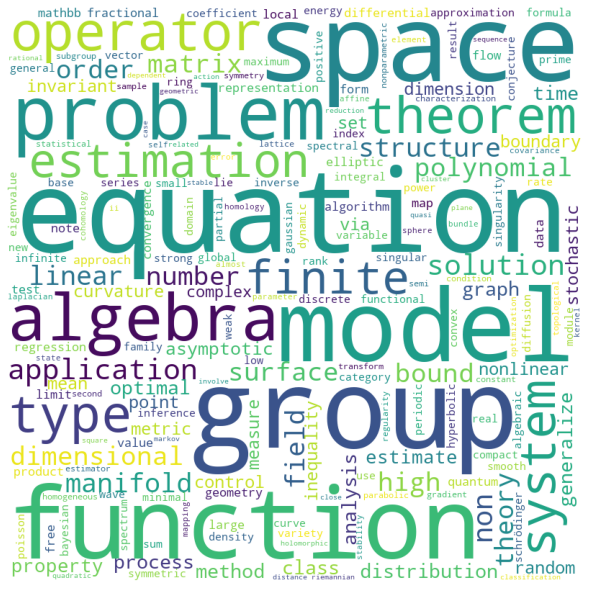

In [44]:
DataExploration.generate_word_cloud(selected_tokens)

## Fit model based on title

In [58]:
train_index, test_index= train_test_split(train.index , test_size = 0.33, random_state = 42)
X_train = train[train.index.isin(train_index)][['TITLE']]
X_test = train[train.index.isin(test_index)][['TITLE']]
y_train = pd.get_dummies(train[train.index.isin(train_index)]['LABEL']).values
y_test = pd.get_dummies(train[train.index.isin(test_index)]['LABEL']).values
X_train = [i for i in X_train.TITLE]
X_test = [i for i in X_test.TITLE]

In [60]:
train['t_len'] = train.TITLE.apply(lambda x: len(x))
max_length = int(train.t_len.quantile(0.99))
max_length

146

In [61]:
t = Tokenizer()
t.fit_on_texts(X_train)

vocab_size = len(t.word_index) + 1
encoded_docs = t.texts_to_sequences(X_train)
padded_docs = pad_sequences(encoded_docs, maxlen = max_length, padding = 'post')
print('Encoding:\n', encoded_docs[0])
print('\nText:\n', list(X_train)[0])
print('\nWord Indices:\n', [(t.index_word[i], i) for i in encoded_docs[0]])
encoded_test_doc = t.texts_to_sequences(X_test)
padded_test_docs = pad_sequences(encoded_test_doc, maxlen = max_length, padding = 'post')

# load the whole embedding into memory
embeddings_index = dict()
# download glove word embedding first and then load it with the following code
f = open('C:/ProgramData/Anaconda3/append_file/glove/glove.6B.100d.txt', encoding = 'utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype = 'float32')
    embeddings_index[word] = coefs
f.close
print('loaded %s word vectors.' % len(embeddings_index))

# Initialize a matrix with zeros having dimensions equivalent to vocab size and 100
embedding_matrix = zeros((vocab_size, 100))
for word, idx_word in t.word_index.items():
    word_vector = embeddings_index.get(word)
    if word_vector is not None:
        embedding_matrix[idx_word] = word_vector
print('word:', t.index_word[1])
print('Embedding:\n', embedding_matrix[1])
print('length of embedding matrix is:', len(embedding_matrix))
print('vocabulary size is %s.' % vocab_size)

Encoding:
 [1031, 1360, 19, 23]

Text:
 Rotation Invariance Neural Network

Word Indices:
 [('rotation', 1031), ('invariance', 1360), ('neural', 19), ('network', 23)]
loaded 400000 word vectors.
word: of
Embedding:
 [-0.1529     -0.24279     0.89837003  0.16996001  0.53516001  0.48784
 -0.58825999 -0.17982    -1.35810006  0.42541     0.15377     0.24214999
  0.13474     0.41192999  0.67043    -0.56418002  0.42985001 -0.012183
 -0.11677     0.31781     0.054177   -0.054273    0.35516    -0.30241001
  0.31434    -0.33846     0.71714997 -0.26855001 -0.15837    -0.47466999
  0.051581   -0.33252001  0.15003    -0.12989999 -0.54617    -0.37843001
  0.64261001  0.82187003 -0.080006    0.078479   -0.96976    -0.57740998
  0.56490999 -0.39873001 -0.057099    0.19743     0.065706   -0.48091999
 -0.20125    -0.40834001  0.39456001 -0.02642    -0.11838     1.01199996
 -0.53171003 -2.74740005 -0.042981   -0.74848998  1.75740004  0.59085
  0.04885     0.78267002  0.38497001  0.42096999  0.67882001  

In [79]:
model = Sequential(
    [
        Embedding(vocab_size, 100, weights = [embedding_matrix], input_length = max_length, trainable = False),
        Flatten(),
        Dense(100, activation="relu", name="layer1"),
        Dense(6, activation = 'softmax', name="layer2")
        
    ]
)
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 146, 100)          1582000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 14600)             0         
_________________________________________________________________
layer1 (Dense)               (None, 100)               1460100   
_________________________________________________________________
layer2 (Dense)               (None, 6)                 606       
Total params: 3,042,706
Trainable params: 1,460,706
Non-trainable params: 1,582,000
_________________________________________________________________
None


In [80]:
# fit the model
history = model.fit(padded_docs, 
                    y_train, 
                    epochs = 5, 
                    verbose = 1, 
                    batch_size = 32, 
                    validation_data = (padded_test_docs, y_test)
                   )

Epoch 1/5
440/440 [==============================] - 6s 11ms/step - loss: 1.0417 - acc: 0.6285 - val_loss: 0.8626 - val_acc: 0.6918
Epoch 2/5
440/440 [==============================] - 5s 11ms/step - loss: 0.7201 - acc: 0.7367 - val_loss: 0.8838 - val_acc: 0.6875
Epoch 3/5
440/440 [==============================] - 5s 11ms/step - loss: 0.5922 - acc: 0.7844 - val_loss: 0.9110 - val_acc: 0.6831
Epoch 4/5
440/440 [==============================] - 4s 10ms/step - loss: 0.4688 - acc: 0.8325 - val_loss: 0.9828 - val_acc: 0.6658
Epoch 5/5
440/440 [==============================] - 4s 10ms/step - loss: 0.3308 - acc: 0.8879 - val_loss: 1.0542 - val_acc: 0.6544


In [81]:
class_names = ['Computer Science','Physics','Mathematics','Statistics','Quantitative Biology','Quantitative Finance']
predsTest = pd.DataFrame(model.predict(padded_test_docs), columns = class_names)
predsTest['pred'] = predsTest.idxmax(axis = 1)
predsTest.head(3)

,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,pred
0,0.896275,0.022792,0.004222,0.001386,8.127509e-04,0.074512,Computer Science
1,0.055207,0.854410,0.080801,0.000039,9.344463e-04,0.008608,Physics
2,0.000009,0.000019,0.999957,0.000001,4.492071e-08,0.000013,Mathematics


Confusion Matrix: 
[[1241  534  802   24   14  184]
 [ 871  363  529    7   10  106]
 [ 649  262  424   11    7   93]
 [ 228  124  173    2    4   38]
 [  61   24   57    1    1   13]
 [  27    9   23    0    0    5]]


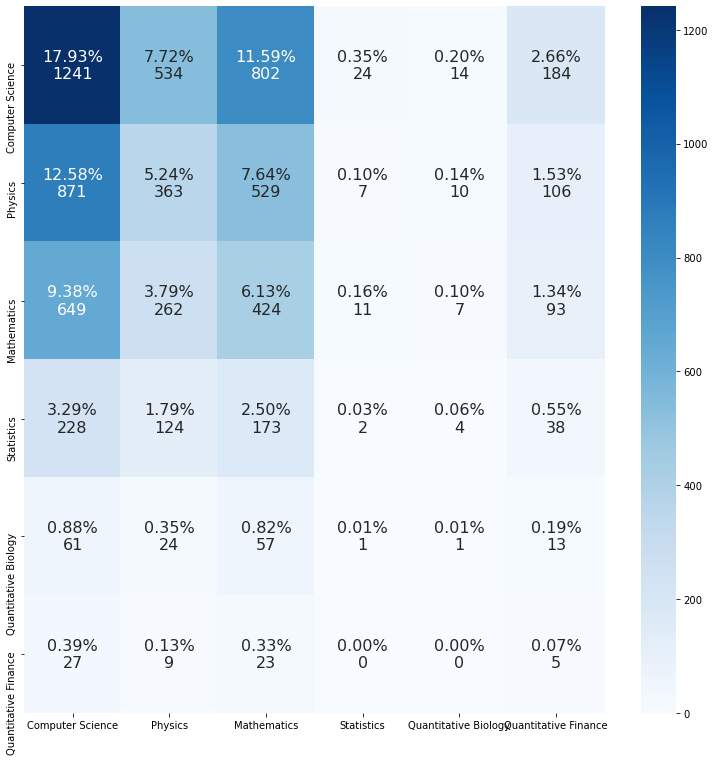

In [83]:
roundedPredsTest = predsTest.pred
print('Confusion Matrix: ')
cf_matrix = confusion_matrix(val[val.index.isin(test_index)]['LABEL'], roundedPredsTest, labels = class_names)
print(cf_matrix)
meplot.cf_matrix_heatmap(cf_matrix, class_names, 13)

In [84]:
print(classification_report(val[val.index.isin(test_index)]['LABEL'], roundedPredsTest))

                      precision    recall  f1-score   support

    Computer Science       0.40      0.44      0.42      2799
         Mathematics       0.21      0.29      0.25      1446
             Physics       0.28      0.19      0.23      1886
Quantitative Biology       0.03      0.01      0.01       157
Quantitative Finance       0.01      0.08      0.02        64
          Statistics       0.04      0.00      0.01       569

            accuracy                           0.29      6921
           macro avg       0.16      0.17      0.16      6921
        weighted avg       0.29      0.29      0.28      6921

